In [1]:
from IPython.display import HTML
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

# Foundations of Data Mining: Assignment 1

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [2]:
# Please fill in your names here
NAME_STUDENT_1 = "Ylja Remmits"
NAME_STUDENT_2 = "Wout de Ruiter"

In [3]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
# InteractiveShell.ast_node_interactivity = "all"

## MoneyBall (5 points, 1+2+1+1)
In the early 2000s, 2 baseball scouts completely changed the game of baseball by analysing the available data about baseball players and hiring the best ones.
The [MoneyBall dataset](https://www.openml.org/d/41021) contains this data (click the link for more details). The goal is to accurately predict the number of 'runs' each player can score. 

In [4]:
moneyball = oml.datasets.get_dataset(41021) # Download MoneyBall data
# Get the predictors X and the target y
X, y, attribute_names = moneyball.get_data(target=moneyball.default_target_attribute, return_attribute_names=True)
# Describe the data with pandas, just to get an overview
ballframe = pd.DataFrame(X, columns=attribute_names)
ballframe_vis = ballframe.copy()
ballframe_vis['target'] = y
ballframe.describe()

,Team,League,Year,RA,...,RankPlayoffs,G,OOBP,OSLG
count,1232.00,1232.0,1232.00,1232.00,...,244.00,1232.00,420.00,420.00
mean,15.67,0.5,1988.96,715.08,...,1.72,3.92,0.33,0.42
std,9.72,0.5,14.82,93.08,...,1.10,0.62,0.02,0.03
min,0.00,0.0,1962.00,472.00,...,0.00,0.00,0.29,0.35
25%,7.00,0.0,1976.75,649.75,...,1.00,4.00,0.32,0.40
50%,16.00,0.5,1989.00,709.00,...,2.00,4.00,0.33,0.42
75%,23.00,1.0,2002.00,774.25,...,3.00,4.00,0.34,0.44
max,38.00,1.0,2012.00,1103.00,...,4.00,7.00,0.38,0.50


1 . Visually explore the data. Plot the distribution of each feature (e.g. histograms), as well as the target. Visualize the dependency of the target on each feature (use a 2d scatter plot). Is there anything that stands out? Is there something that you think might require special treatment?
- Feel free to create additional plots that help you understand the data
- Only visualize the data, you don't need to change it (yet)

Team           -0.11
League         -0.19
Year            0.42
RA              0.38
W               0.51
OBP             0.90
SLG             0.92
BA              0.83
Playoffs        0.39
RankSeason     -0.03
RankPlayoffs    0.21
G               0.08
OOBP            0.13
OSLG            0.19
target          1.00
Name: target, dtype: float64


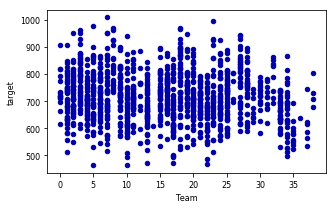

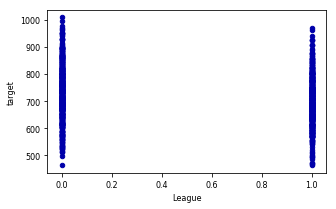

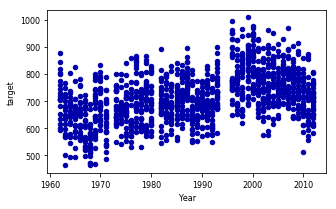

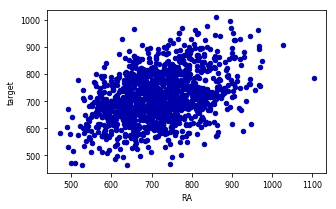

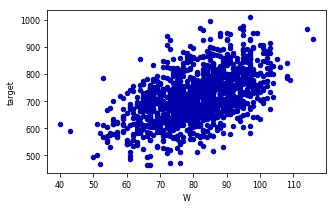

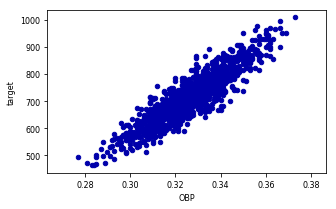

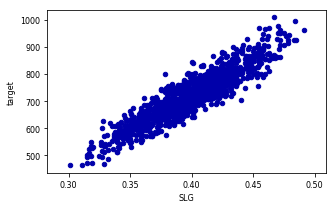

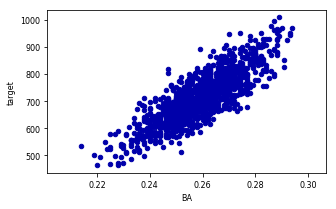

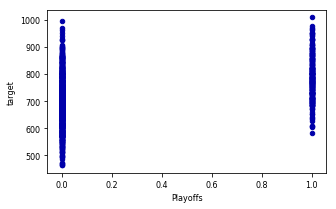

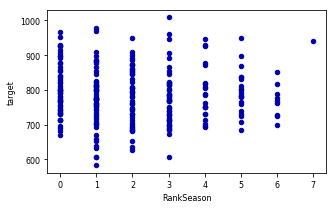

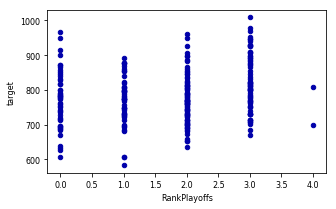

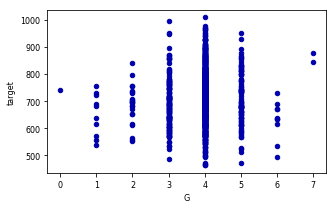

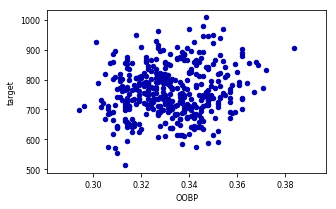

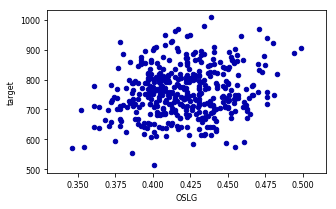

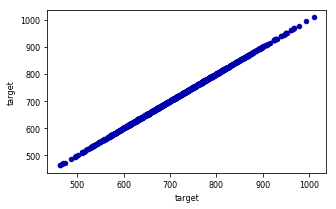

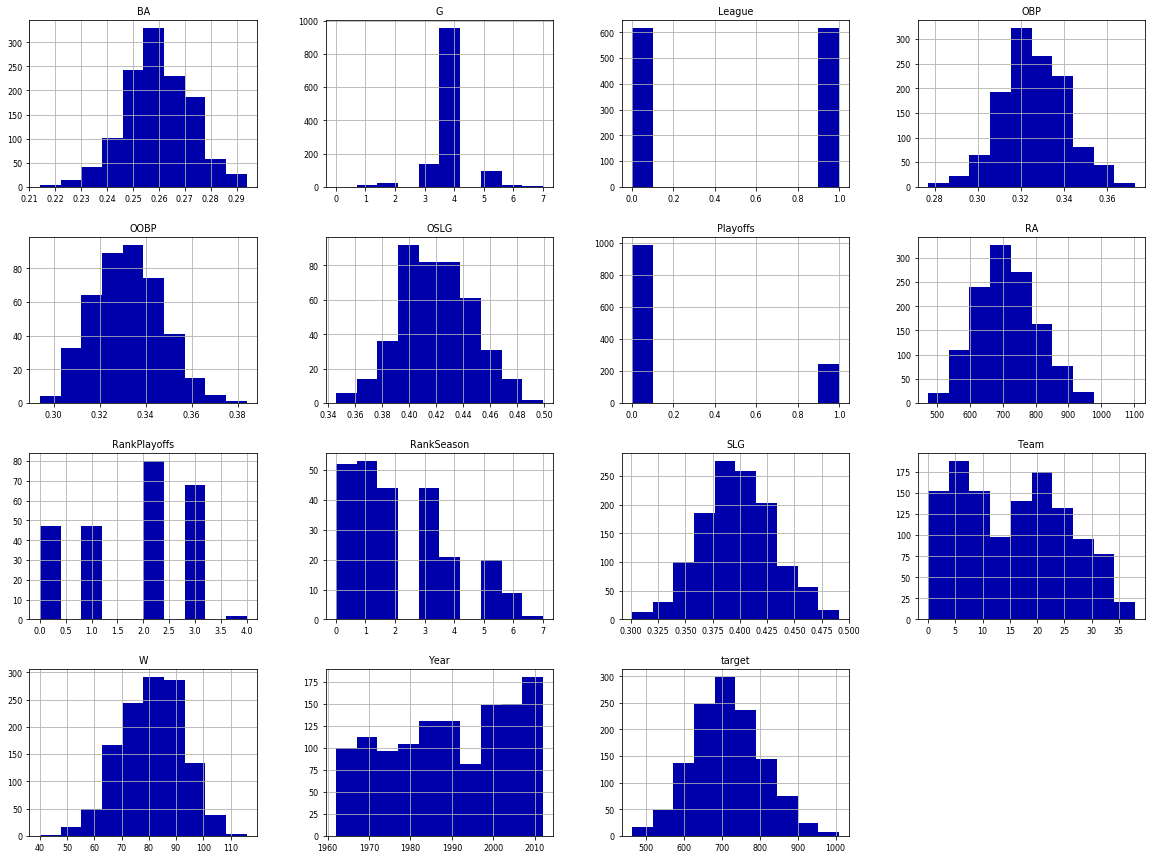

In [5]:
for feature in ballframe_vis.columns:
    ballframe_vis.plot(x=feature, y="target", kind="scatter")
ballframe_vis.hist(figsize=(20,15))
print(ballframe_vis.corr()["target"]);

2 . Compare all linear regression algorithms that we covered in class (Linear Regression, Ridge, Lasso and ElasticNet), as well as kNN. Evaluate using cross-validation and the $R^2$ score, with the default parameters. Does scaling the data with StandardScaler help? Provide a concise but meaningful interpretation of the results.
- Preprocess the data as needed (e.g. are there nominal features that are not ordinal?). If you don't know how to proceed, remove the feature and continue.

### Motivation of preprocessing:

'Team' is a nomimal feature that is not ordinal. We removed this feature.  Upon visual inspection we find that 'Year' and 'G' (the number of games played) might not have a linear relation to the target. Therefore we add polynomial features (up to a degree of 3) for these two features. We did not add interaction features.

For four features most data(more than 65% of points) is missing: 'RankSeason', 'RankPlayoffs', 'OOBP', 'OSLG'. We decided to remove these features.



In [6]:
# preprocessing
from sklearn.preprocessing import PolynomialFeatures

#add dummies
# ballframe_wdummies = pd.get_dummies(ballframe, columns=['Team'])
#add polynomial features, no interaction features
poly = PolynomialFeatures(degree=3, include_bias=False)
df_p = pd.DataFrame(poly.fit_transform(ballframe[['Year', 'G']]), columns=['Year', 'G', 'Year^2', 'YearxG', 'G^2', 'Year^3', 'Year^2xG', 'YearxG^2', 'G^3'])
df_poly = df_p[['Year^2', 'G^2', 'Year^3', 'G^3']]
x_complete = pd.concat([ballframe, df_poly], axis=1)

In [7]:
totlen = len(x_complete)
print('Total nr of datapoints: {}'.format(totlen))
print('nr nan for rank season: {}, missing {}%'.format(x_complete['RankSeason'].isna().sum(), x_complete['RankSeason'].isna().sum()/totlen*100))
print('nr nan for rank playoffs: {}, missing {}%'.format(x_complete['RankPlayoffs'].isna().sum(), x_complete['RankPlayoffs'].isna().sum()/totlen*100))
print('nr nan for rank oobp: {}, missing {}%'.format(x_complete['OOBP'].isna().sum(), x_complete['OOBP'].isna().sum()/totlen*100))
print('nr nan for rank oslg: {}, missing {}%'.format(x_complete['OSLG'].isna().sum(), x_complete['OSLG'].isna().sum()/totlen*100))
x_complete = x_complete.drop(columns=['RankSeason', 'RankPlayoffs', 'OOBP', 'OSLG', 'Team'])
x_complete.head()

Total nr of datapoints: 1232
nr nan for rank season: 988, missing 80.1948051948052%
nr nan for rank playoffs: 988, missing 80.1948051948052%
nr nan for rank oobp: 812, missing 65.9090909090909%
nr nan for rank oslg: 812, missing 65.9090909090909%


,League,Year,RA,W,...,Year^2,G^2,Year^3,G^3
0,1.0,2012.0,688.0,81.0,...,4.05e+06,16.0,8.14e+09,64.0
1,1.0,2012.0,600.0,94.0,...,4.05e+06,16.0,8.14e+09,64.0
2,0.0,2012.0,705.0,93.0,...,4.05e+06,16.0,8.14e+09,64.0
3,0.0,2012.0,806.0,69.0,...,4.05e+06,16.0,8.14e+09,64.0
4,1.0,2012.0,759.0,61.0,...,4.05e+06,16.0,8.14e+09,64.0


In [8]:
from sklearn.pipeline import make_pipeline
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import ShuffleSplit


#define test methods and features
# x_complete = ballframe[["OBP", "SLG", "BA"]];
testMethods = [["linear regression", linear_model.LinearRegression()],
               ["Ridge", Ridge()],
               ["lasso", Lasso()],
               ["nearest neighbours", KNeighborsRegressor()],
               ["Elastic Net", ElasticNet()]];

# folds
from sklearn.model_selection import KFold
kfold = KFold(shuffle=True)



#define datasets
# x_train, x_test, y_train, y_test = train_test_split(x_complete, y);


#do testing
for method in testMethods:
    print(method[0])
    method = method[1]
    pipe = make_pipeline(StandardScaler(), method)
    scores_scaled = cross_val_score(pipe, x_complete, y, cv=kfold)
#     pipe.fit(x_train, y_train)
    scores = cross_val_score(method, x_complete, y, cv=kfold)
#     method.fit()
#     print("With Scaling  - R2 Score : {:.2f}".format(pipe.score(x_test, y_test)));    
    print("With Scaling  - Cross-validation scores: {}".format(scores_scaled));
#     print("No Scaling  - R2 Score : {:.2f}".format(pipe.score(x_test, y_test)));    
    print("No Scaling  - Cross-validation scores: {}\n".format(scores));



linear regression
With Scaling  - Cross-validation scores: [0.945 0.943 0.95 ]
No Scaling  - Cross-validation scores: [0.944 0.944 0.954]

Ridge
With Scaling  - Cross-validation scores: [0.949 0.949 0.941]
No Scaling  - Cross-validation scores: [0.871 0.885 0.891]

lasso
With Scaling  - Cross-validation scores: [0.943 0.94  0.952]
No Scaling  - Cross-validation scores: [0.863 0.841 0.862]

nearest neighbours
With Scaling  - Cross-validation scores: [0.874 0.857 0.874]
No Scaling  - Cross-validation scores: [0.356 0.381 0.234]

Elastic Net
With Scaling  - Cross-validation scores: [0.904 0.909 0.91 ]
No Scaling  - Cross-validation scores: [0.865 0.86  0.847]



### Interpretation of results
We kan see that KNN improves most from scaling. This is to be expected since the euclidean distance is heavily influenced by different scales for different features.

We can see that Linear regression does not improve from scaling. This also make sense since the regression weights can be seen as a form of scaling that is internal to the model.

Ridge, Lasso and Elastic all improve moderately form scaling.

3 . Do a default, shuffled train-test split and optimize the linear models for the degree of regularization ($alpha$) and choice of penalty (L1/L2). For Ridge and  Lasso, plot a curve showing the effect of the training and test set performance ($R^2$) while increasing the degree of regularization for different penalties. For ElasticNet, plot a heatmap $alpha \times l1\_ratio \rightarrow R^2$ using test set performance.
Report the optimal performance. Again, provide a concise but meaningful interpretation. What does the regularization do? Can you get better results?
- Think about how you get the L1/L2 loss. This is not a hyperparameter in regression.
- We've seen how to generate such heatmaps in Lecture 3.

### 1.3 Interpretation of results

Optimal performance is achieved for the smallest alpha: $\alpha$ = 0.1, for all three classifiers.

Small alpha results means less regularization. Lasso uses L1 penalty in regularization and Ridge uses L2 penalty. appearantly the model does not benifit from large regularization towards small weights (Ridge) or sparcity (lasso).

We can see that the results for Elastic Net are best with l1_ratio = 1. This means it uses only L1 penalty.

We might be able to get better results when choosing ever smaller values for the parameters.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_complete, y, random_state=1232156);

scaler = MinMaxScaler()
scaler.fit(x_train)
X_train_scaled = scaler.transform(x_train)
X_test_scaled = scaler.transform(x_test)

# x_transformed_train = scaler.transform(x_train);
# x_transformed_test = scaler.transform(x_test);
# x_transformed_complete = scaler.transform(x_complete);

testMethods = [["Lasso", Lasso()], #L1 error
               ["Ridge", Ridge()], #L2 error               
               ["Elastic Net", ElasticNet()]]; #super combi deal

l1l2Coefficient = [[-1], [-1], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]]

# datasets = [["normal training set", x_train, y_train], 
#            ["transformed training set", x_transformed_train, y_train],
#            ["normal test set", x_test, y_test, x_complete, y],
#            ["transformed test set", x_transformed_test, y_test, x_transformed_complete, y]];

alphas = np.logspace(0, 1, 20)/10
print (alphas)

#do testing
results = []
for i, method in enumerate(testMethods):
    print(method[0])
    method = method[1]
    resultsMethod = []
    coefficients = l1l2Coefficient[i]
    pipe = make_pipeline(StandardScaler(), method)
    for a in alphas:
        score = []
        for coef in coefficients:
            if coef>=0: 
               method.set_params(l1_ratio=coef);            
            method.set_params(alpha=a);
            method.fit(X_train_scaled, y_train);
            if coef>=0: 
                score.append(method.score(X_test_scaled, y_test))
#                  print(method.score(X=x_test, y=y_test))
            else:
                score = (method.score(X_train_scaled, y_train), method.score(X_test_scaled, y_test));
#                 print(score)
        resultsMethod.append(score);
    results.append(resultsMethod);
    

[0.1   0.113 0.127 0.144 0.162 0.183 0.207 0.234 0.264 0.298 0.336 0.379
 0.428 0.483 0.546 0.616 0.695 0.785 0.886 1.   ]
Lasso
Ridge
Elastic Net


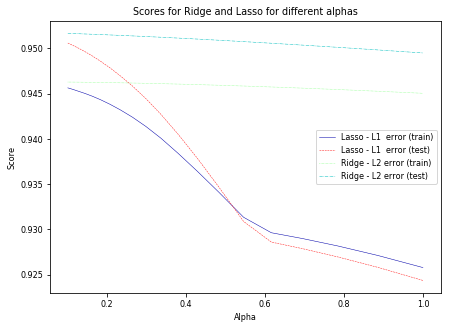

In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (7,5)

#graph of lasso en ridge
lassoResults_train = [train for train, _ in results[0]]
lassoResults_test = [test for _, test in results[0]]
ridgeResults_train = [train for train, _ in results[1]]
ridgeResults_test = [test for _, test in results[1]]

plt.plot(alphas, lassoResults_train);
plt.plot(alphas, lassoResults_test);
plt.plot(alphas, ridgeResults_train);
plt.plot(alphas, ridgeResults_test);
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.legend(['Lasso - L1  error (train)', 'Lasso - L1  error (test)', 'Ridge - L2 error (train)', 'Ridge - L2 error (test)'], loc='center right')
plt.title('Scores for Ridge and Lasso for different alphas')
plt.show();

In [11]:
elasticNetResults = pd.DataFrame(results[2], columns=coefficients, index=alphas)

(20, 10)


Text(70,0.5,'Alpha')

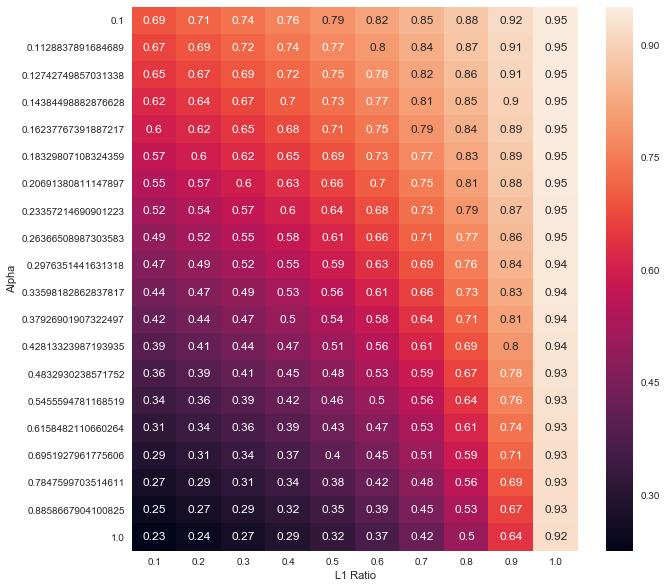

In [12]:
#Make the heatmap

import seaborn as sns; sns.set()
from matplotlib import pyplot
# elasticNetResults = np.array(results[2])
print(elasticNetResults.shape)
fig, ax = pyplot.subplots(figsize=(10,10))
ax = sns.heatmap(elasticNetResults, annot=True)
ax.set_xlabel('L1 Ratio')
ax.set_ylabel('Alpha')
# mglearn.tools.heatmap(elasticNetResults, xticklabels=elasticNetResults.columns, xlabel='L1 Ratio', ylabel='Alpha', yticklabels=elasticNetResults.index)




4 . Visualize the coefficients of the optimized models. Do they agree on which features are
important? Compare the results with the feature importances returned by a RandomForest. Does it agree with the linear models? What would look for when scouting for a baseball player?

### 1.4 Interpretation of results
In Both Ridge and Lasso the same four features are most important for the prediction: 'RA', 'W', 'OBP' and 'SLG', with 'OBP' and 'SLG' having the largest weights.
For Elastic Net multiple features are moderately important, but also here 'OBP' and 'SLG' are most important. 

If we look at the results from the random forest we can see that 'OBP' and 'SLG' are most inportant.

In the choice of most important features all models agree. However there are differences is we look at all features used.

When scouting baseball players one should mostly look for On-Base Percentage (OBP) and Slugging Percentage (SLG).

('RA', 'W', 'OBP', 'SLG')

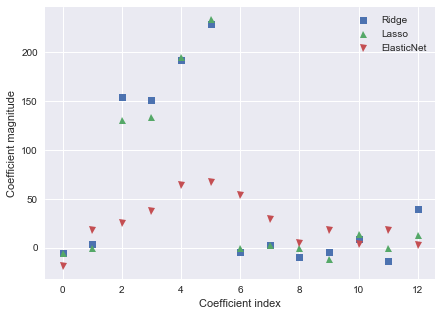

In [13]:
# visualise optimized results
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (7,5)

ridge = Ridge(alpha=0.1)
lasso = Lasso(alpha=0.1)
elastic = ElasticNet(alpha=0.1, l1_ratio=0)
ridge.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train)
elastic.fit(X_train_scaled, y_train)

plt.plot(ridge.coef_, 's', label="Ridge")
plt.plot(lasso.coef_, '^', label="Lasso")
plt.plot(elastic.coef_, 'v', label="ElasticNet")

plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
# plt.hlines(0, 0, len(lr.coef_))
# plt.ylim(-25, 25)
plt.legend()

x_complete.columns[2], x_complete.columns[3], x_complete.columns[4], x_complete.columns[5]

(-1, 13)

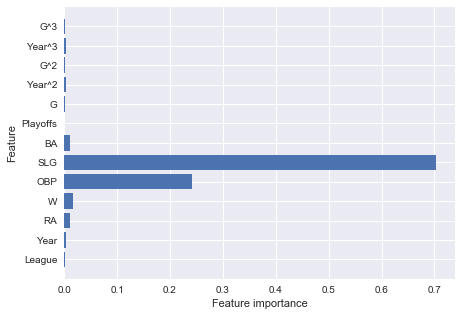

In [14]:
#random forrest
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(random_state=2)
forest.fit(X_train_scaled, y_train) 


n_features = len(x_complete.columns)
plt.barh(range(n_features), forest.feature_importances_, align='center')
plt.yticks(np.arange(n_features), x_complete.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.ylim(-1, n_features)


In [15]:
x_complete.columns[2], x_complete.columns[3], x_complete.columns[4], x_complete.columns[5]

('RA', 'W', 'OBP', 'SLG')

## Nepalese character recognition (5 points, 1+2+2)
The [Devnagari-Script dataset](https://www.openml.org/d/40923) contains 92,000 images (32x32 pixels) of 46 characters from Devanagari script. Your goal is to learn to recognize the right letter given the image.

In [16]:
devnagari = oml.datasets.get_dataset(40923) # Download Devnagari data
# Get the predictors X and the labels y
X, y = devnagari.get_data(target=devnagari.default_target_attribute); 
#classes = devnagari.retrieve_class_labels(target_name='character') # This one takes a while, skip if not needed

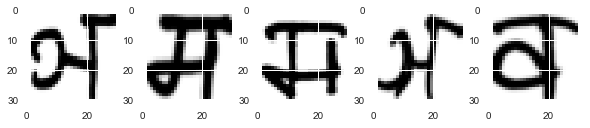

In [17]:
from random import randint
# Take some random examples, reshape to a 32x32 image and plot
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,90000)
    axes[i].imshow(X[n].reshape(32, 32), cmap=plt.cm.gray_r)
    #axes[i].set_xlabel("Class: %s" % (classes[y[n]]))
plt.show();

In [33]:
#remove 99% of the data for testing purposes
#X, _, y, _ = train_test_split(X, y,  test_size=0.99, stratify=y)

1024


1. Evaluate k-Nearest Neighbors, Logistic Regression and RandomForests with their default settings.
    - Take a stratified 10% subsample of the data.
    - Use the default train-test split and predictive accuracy. Is predictive accuracy a good scoring measure for this problem?
    - Try to build the same models on increasingly large samples of the dataset (e.g. 10%, 20%,...). Plot the training time and the predictive performance for each. Stop when the training time becomes prohibitively large (this will be different for different models). 

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
import multiprocessing
from time import time

def calculateModel(method, x_train, x_test, y_train, y_test, chunking = False):
    startTime = time()    
    method.fit(x_train, y_train)
    score = method.score(x_test, y_test)
    totalTime = time() - startTime
    return score, totalTime
    #splits = 10
    #if chunking == True:
    #    for i in range(int(len(x_train)/splits)+1):
    #        minIndex = i*splits
    #        maxIndex = ((i+1)*splits)
    #        if maxIndex>len(x_train): 
    #            maxIndex=len(x_train)
    #        if minIndex == maxIndex:
    #            break
    #        split_x = x_train[minIndex:maxIndex]
    #        split_y = y_train[minIndex:maxIndex]
    #        method.fit(split_x, split_y)
    #        print("training: "+ str(i*(100/splits)) + " percent complete - testing: 0 percent complete        \r", end="")
    #else:
    #    print("training: 0 percent complete - testing: 0 percent complete        \r", end="")
    #    method.fit(x_train, y_train)
    #    print("training: 100 percent complete - testing: 0 percent complete       \r", end="")
        
    #scores = []
    #for i in range(int(len(x_train)/splits)+1):
    #    minIndex = i*splits
    #    maxIndex = ((i+1)*splits)
    #    if maxIndex>len(x_test): 
    #        maxIndex=len(x_test)
    #    if maxIndex == minIndex:
    #        break
    #    split_x = x_test[i*splits:(i+1)*splits]
    #    split_y = y_test[i*splits:(i+1)*splits]
    #    scores.append(method.score(split_x, split_y)/float(len(split_x)));
    #    print("training: 100 percent complete - testing: "+ str(i*(100/splits)) +"percent complete         \r", end="")
    #print("training: 100 percent complete - testing: 100 percent complete")
    
    


globalStartTime = time()
stop = False
trainingPercentage = 0.0
scores = []
stopModels = []

while(trainingPercentage<0.35):
    print("---")
    testMethods = [["Logistic Regression", True, LogisticRegression(n_jobs=-1, verbose=1)],
               ["Nearest Neighbours", False, KNeighborsRegressor()],
               ["Random Forests", True, RandomForestRegressor(n_jobs=-1, verbose=1)]];

    
    trainingPercentage += 0.1
    failures = 0
    
    #Take the stratified subsamples
    if trainingPercentage<0.95:
        X_used, _, y_used, _ = train_test_split(X, y,  test_size=1-trainingPercentage, stratify=y)
    else:
        X_used = X
        y_used = y
    
    #define datasets
    x_train, x_test, y_train, y_test = train_test_split(X_used, y_used, random_state=456468, test_size=0.25);
    
    
    modelResults = []
    for i in range(len(testMethods)):
        startTime = time()
        stopTime = startTime + (1000 * 1000 * 60 * 20) #stop always after 20 minutes of calculation
        if i in stopModels:
            modelResults.append(0)
            print("Test method {:20} not completed because of time with trainingspercentage {:.2f}"
                  .format(testMethods[i][0], trainingPercentage))
        else:
            score, calcTime = calculateModel(testMethods[i][2], x_train, x_test, y_train, y_test, testMethods[i][1])
            modelResults.append(score)
            print("Test method {:20} took {:8.2f} seconds to complete with trainingspercentage {:.2f}      Result: {:.4f}"
                  .format(testMethods[i][0], calcTime, trainingPercentage, score))
            
    scores.append(modelResults)
    if(len(stopModels)>2):
        break
    
globalStopTime = time()                  
print ("total time: %.2f seconds" % (time()-globalStartTime))
    
    
    
    #MANUAL MULTIPROCESSING DOES NOT WORK IN JUPYTER NOTEBOOK
    #startTime = time.time()
    #stopTime = startTime + (1000 * 1000 * 60 * 20) #stop always after 20 minutes of calculation
    
    
    #manager = multiprocessing.Manager()
    #returnDict = manager.dict()
    #jobs = []
    #for i in range(len(testMethods)):
        #p = multiprocessing.Process(target=calculateModel, args=(i, testMethods[i], x_train, x_test, y_train, y_test, returnDict))
        #jobs.append(p)
        #p.start()
        #print("start job " + str(i) + " with pid " + p.pid)
    
    #for i in range(len(testMethods)):
        #print("joining processses" + str((stopTime-time.time())/1000/1000))
        #if (stopTime-time.time()) > 1000 * 1000 * 10: #if more than 10 seconds are left
            #jobs[i].join((stopTime-time.time())/1000/1000)
        
        #if jobs[i].is_alive():
            #print("terminating")
            #jobs[i].terminate()
            #jobs[i].join()
            
            #returnDict[procnum] = [0, -1]
            
            #failures += 1
            #print("testmethod " + testMethods[i][0] + "aborted after " 
            #+ str((time.time() - startTime)/1000.0/1000.0/60.0) + " minutes with trainingspercentage " + trainingPercentage)

    #if failures>len(testMethods)-1:
        #stop = True
        
    
    




---
[LibLinear]Test method Logistic Regression  took   142.83 seconds to complete with trainingspercentage 0.10      Result: 0.4861
Test method Nearest Neighbours   took    21.16 seconds to complete with trainingspercentage 0.10      Result: 0.7435


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.1s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


Test method Random Forests       took     3.59 seconds to complete with trainingspercentage 0.10      Result: 0.4540
---
[LibLinear]Test method Logistic Regression  took  2407.47 seconds to complete with trainingspercentage 0.20      Result: 0.4543
Test method Nearest Neighbours   took    84.17 seconds to complete with trainingspercentage 0.20      Result: 0.8132


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.1s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.7s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


Test method Random Forests       took     7.03 seconds to complete with trainingspercentage 0.20      Result: 0.5567
---
[LibLinear]Test method Logistic Regression  took  7073.71 seconds to complete with trainingspercentage 0.30      Result: 0.5243
Test method Nearest Neighbours   took   203.89 seconds to complete with trainingspercentage 0.30      Result: 0.8552


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    7.2s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.3s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


Test method Random Forests       took    11.64 seconds to complete with trainingspercentage 0.30      Result: 0.5860
---
[LibLinear]Test method Logistic Regression  took 10253.98 seconds to complete with trainingspercentage 0.40      Result: 0.5871
Test method Nearest Neighbours   took   339.28 seconds to complete with trainingspercentage 0.40      Result: 0.8653


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    9.6s remaining:    6.4s


Test method Random Forests       took    15.58 seconds to complete with trainingspercentage 0.40      Result: 0.6027
total time: 20566.94 seconds


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.3s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


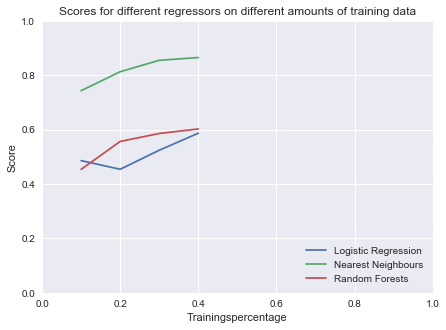

In [23]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (7,5)

scoresPerMethod = list(zip(*scores))
trainingsPercentages = np.linspace(0.1,0.4,4)


plt.plot(trainingsPercentages, scoresPerMethod[0]);
plt.plot(trainingsPercentages, scoresPerMethod[1]);
plt.plot(trainingsPercentages, scoresPerMethod[2]);
plt.xlabel('Trainingspercentage')
plt.ylabel('Score')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(['Logistic Regression', 'Nearest Neighbours', 'Random Forests'], loc='lower right')
plt.title('Scores for different regressors on different amounts of training data')
plt.show();


### interpertation

We only calculated for 40% of the data because of the timewise problems of calculating longer. The logistic regression is very very slow. This is probably the case because it is searching for local minima. The local minima in a 1024 features = 1024 dimensions without any clue of how the variables interact is a bit hard. It is also hard since multiple points have to be calculated to know in which direction to move, more dimensions is more incorrect moves. On top of that we use the liblinear library which is not well suited for large datasets and many features on a non binary amount of classes. Hence Another solver would have helped too but unfortunately this was forbidden by the exercise.

The nearest neigbour solution is also slower. Especially the prediction of the test data is very hard since it has to calculate the closest neighbours in a 1024 dimensional space. The results are however the best among all regressors. We think this is because the closest neighbors approach does not require a formula with a limited complexity. When the right amount of neighbours is selected areas with unlimited complexity can be created. A point is classified by the area it is positioned in.

As last one we got the random forest regressor. It gives very fast results mainly because it subsamples the the data internally making the computation easier. The amount of trees is low. Making it extremely easy to calculate in comparison to the other methods. Also all trees can be calculated at the same time meaning that multiprocessor machines can speed it up even more.
The results of this method are quite good when you keep in mind that only 10 trees are calculated and averaged.

2 . Optimize the value for the number of neighbors $k$ (keep $k$ < 50) and the number of trees (keep $n\_estimators$ < 100) on the stratified 10% subsample.
- Use 10-fold crossvalidation and plot $k$ and $n\_estimators$ against the predictive accuracy. Which value of $k$, $n\_estimators$ should you pick?

In [24]:
from sklearn.model_selection import GridSearchCV, KFold
estimators = 0

#Take the stratified subsamples
X_used, _, y_used, _ = train_test_split(X, y,  test_size=0.9, stratify=y)

model = RandomForestRegressor()
parameters = [{'n_estimators':np.arange(1,100,5)}]
crossValidator = KFold(n_splits=10, shuffle=True, random_state=312315644)
GSRandomForest = GridSearchCV(model, parameters, n_jobs=-1, verbose=2, cv=crossValidator)
GSRandomForest.fit(X_used, y_used )


Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 26.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 48.6min finished


GridSearchCV(cv=KFold(n_splits=10, random_state=312315644, shuffle=True),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

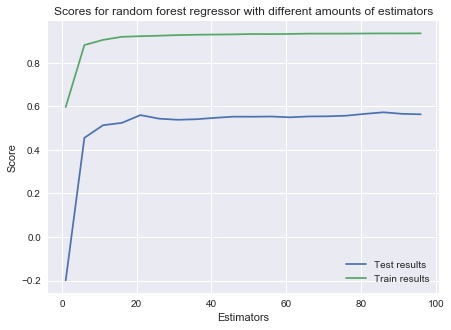

In [25]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (7,5)
testSplitResults = []
trainSplitResults = []
for i in range(10):
    key = "split{}_test_score".format(i)
    testSplitResults.append(GSRandomForest.cv_results_[key])
    key = "split{}_train_score".format(i)
    trainSplitResults.append(GSRandomForest.cv_results_[key])
    
testResults = list(zip(*testSplitResults))
trainResults = list(zip(*trainSplitResults))
for i in range(len(testResults)):
    testResults[i] = np.mean(testResults[i][0])
    trainResults[i] = np.mean(trainResults[i][0])
    
xValues = np.arange(1,100,5)
plt.plot(xValues, testResults);
plt.plot(xValues, trainResults);
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.legend(['Test results', 'Train results'], loc='lower right')
plt.title('Scores for random forest regressor with different amounts of estimators')
plt.show();

### Interpertation

Here we try different versions for the amount of estimators in a randomforest regressor. We notice that less than 10 estimators is just a disaster for your model. With so little estimators a guess is even better. Then further on we see that more than 10 estimators does not really improve your results but do make your model more complex. This may indicate that 10 is the optimal value, but it might also be more if orther parameters of the model are changed

In [26]:
#Take the stratified subsamples
X_used, _, y_used, _ = train_test_split(X, y,  test_size=0.9, stratify=y)
#define datasets

model = KNeighborsRegressor()
parameters = [{'n_neighbors':np.arange(1,50,5)}]
crossValidator = KFold(n_splits=10, shuffle=True, random_state=312315644)
GSNearestNeighbors = GridSearchCV(model, parameters, n_jobs=-1, cv=crossValidator, verbose=1)
GSNearestNeighbors.fit(X_used, y_used )

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 44.6min finished


GridSearchCV(cv=KFold(n_splits=10, random_state=312315644, shuffle=True),
       error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_neighbors': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

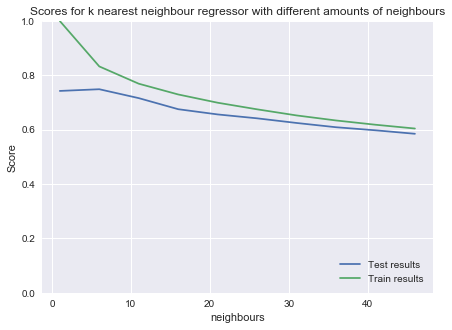

In [32]:
import matplotlib.pyplot as plt

testSplitResults = []
trainSplitResults = []
for i in range(10):
    key = "split{}_test_score".format(i)
    testSplitResults.append(GSNearestNeighbors.cv_results_[key])
    key = "split{}_train_score".format(i)
    trainSplitResults.append(GSNearestNeighbors.cv_results_[key])
    
testResults = list(zip(*testSplitResults))
trainResults = list(zip(*trainSplitResults))
for i in range(len(testResults)):
    testResults[i] = np.mean(testResults[i][0])
    trainResults[i] = np.mean(trainResults[i][0])
    
xValues = np.arange(1,50,5)
plt.plot(xValues, testResults);
plt.plot(xValues, trainResults);
plt.xlabel('neighbours')
plt.ylabel('Score')
plt.ylim(0,1)

plt.legend(['Test results', 'Train results'], loc='lower right')
plt.title('Scores for k nearest neighbour regressor with different amounts of neighbours')
plt.show();

### Interpertation
We researched the k-nearest neigbour regressor here and tried to find an optimum in the amount of neighbours that give the best results. Unfortunately we made to large jumps with the parameter for the amount of neighbours. Normally there would be a peak somewhere in the graph, unfortunately it is now barely visible since we spread out the points uniformly. A logspace would perhaps have been a better idea.

What we can see is that at 5 neigbours there is an increase in the test score and a decrease in the train score. This means that 5 is closer to the optimum of an estimation error and an approximation error. The further we go from there we see a decline in both train and test results indicating an total decrease in quality of the model.

3 . For the RandomForest, optimize both $n\_estimators$ and $max\_features$ at the same time on the entire dataset.
- Use a nested cross-validation and a random search over the possible values, and measure the accuracy. Explore how fine-grained this random search can be, given your computational resources. What is the optimal performance you find?
- Hint: choose a nested cross-validation that is feasible. Don't use too many folds in the outer loop.
- Repeat the grid search and visualize the results as a plot (heatmap) $n\_estimators \times max\_features \rightarrow ACC$ with ACC visualized as the color of the data point. Try to make the grid as fine as possible. Interpret the results. Can you explain your observations? What did you learn about tuning RandomForests?

In [28]:
from scipy.stats import randint
from scipy.stats import uniform
from random import random
from sklearn.model_selection import RandomizedSearchCV
from time import time

startTime = time()

inner_cv = KFold(n_splits=6, shuffle=True, random_state=i)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=i)
model = RandomForestRegressor()

param_dist = {"n_estimators": randint(1, 100),
              "max_features": uniform()}

# Non_nested parameter search and scoring
nonNestedSearch = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=inner_cv, n_jobs=-1, verbose=1)
nonNestedSearch.fit(X, y)
bestScoreNonNested = nonNestedSearch.best_score_

# Nested CV with parameter optimization
nestedInnerCV = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=inner_cv, n_jobs=-1, verbose=1)
nested_scores = cross_val_score(nestedInnerCV, X=X, y=y, cv=outer_cv, verbose=1)

print ("Calculation time: %.2f seconds" % (time()-startTime))

Fitting 6 folds for each of 10 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 56.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 97.9min finished


Fitting 6 folds for each of 10 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 40.8min finished


Fitting 6 folds for each of 10 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 53.2min finished


Fitting 6 folds for each of 10 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 58.1min finished


Calculation time: 16584.34 seconds


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 165.8min finished


In [29]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
mpl.rcParams['figure.figsize'] = (7,5)

xValues = []
yValues = []
for param in nonNestedSearch.cv_results_["params"]:
    xValues.append(param["max_features"])
    yValues.append(param["n_estimators"])
    
testSplitResults = []
trainSplitResults = []
for i in range(nonNestedSearch.n_splits_):        
    key = "split{}_test_score".format(i)
    testSplitResults.append(nonNestedSearch.cv_results_[key])
    key = "split{}_train_score".format(i)
    trainSplitResults.append(nonNestedSearch.cv_results_[key])
    
testResults = list(zip(*testSplitResults))
trainResults = list(zip(*trainSplitResults))

for i in range(len(testResults)):
    testResults[i] = np.mean(testResults[i][0])
    trainResults[i] = np.mean(trainResults[i][0])
    
for i in range(len(xValues)):
    print("non Nested Random Search {} had features={:0.4f} and percentage of estimators={:2.0f}, the score was {:.4f}"
          .format(i, xValues[i], yValues[i], testResults[i] ))


print("nested test scores were {:.4f}, {:.4f} and {:.4f} with as mean {:.4f}".format(
      nested_scores[0], nested_scores[1], nested_scores[2], np.mean(nested_scores)))
    

non Nested Random Search 0 had features=0.1814 and percentage of estimators= 3, the score was 0.5656
non Nested Random Search 1 had features=0.4354 and percentage of estimators=41, the score was 0.7311
non Nested Random Search 2 had features=0.1286 and percentage of estimators=70, the score was 0.7358
non Nested Random Search 3 had features=0.5989 and percentage of estimators=74, the score was 0.7376
non Nested Random Search 4 had features=0.2305 and percentage of estimators=38, the score was 0.7321
non Nested Random Search 5 had features=0.5870 and percentage of estimators=78, the score was 0.7369
non Nested Random Search 6 had features=0.8911 and percentage of estimators=63, the score was 0.7299
non Nested Random Search 7 had features=0.7951 and percentage of estimators=33, the score was 0.7272
non Nested Random Search 8 had features=0.3662 and percentage of estimators=91, the score was 0.7396
non Nested Random Search 9 had features=0.0348 and percentage of estimators=67, the score w

### Interpertation

Here we did a random search for the optimal values for the hyperparameters $max_features$ and $n_estimators$ in a random forest regression. We also did a nested cross validation meaning that the answers from multiple random searches are compared with each other.

In the random search we discovered different results. We know that the results for the given parameters are accurate because we did them in a 6 fold cross validation. The mean score from those 6 validations is reported. When we got 10 different points selected at random in the data they probably give a decent idea of what is possible with the data. So given our model and these hyperparameters we can argue that a score produced by these searches give a average of what can be achieved with this dataset and by tweaking these parameters.

The nested cross validation gives us even more certainty. The test we mentioned before is repeated three times to make it more robust to random searches that explore only a part of the domain of a hyperparameter. The mean of the nested crossvalidation thus gives an idea about variance and mean of the results that can be generated by these hyperparameters.

In this case is a score of 0.7177 means that the model can be quite good if the parameters are tweaked correctly. These parameters could also be extracted from the non-nested cross-validators which would give an idea of where the actual optimum really lies.

In [30]:
#define datasets

model = RandomForestRegressor()
parameters = [{'n_estimators':np.arange(10,115,15),
              "max_features": np.linspace(0.1,1,8)}]
crossValidator = KFold(n_splits=3, shuffle=True, random_state=312315644)
GSRandomForestComplete = GridSearchCV(model, parameters, n_jobs=-1, cv=crossValidator, verbose=1)
GSRandomForestComplete.fit(X, y )

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed: 263.0min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=312315644, shuffle=True),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': array([ 10,  25,  40,  55,  70,  85, 100]), 'max_features': array([0.1    , 0.22857, 0.35714, 0.48571, 0.61429, 0.74286, 0.87143,
       1.     ])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

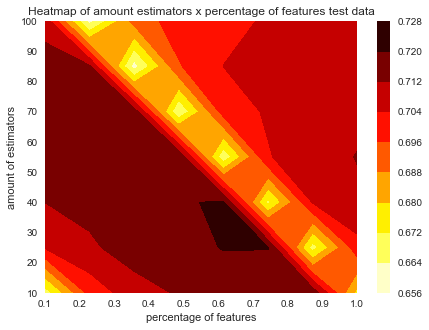

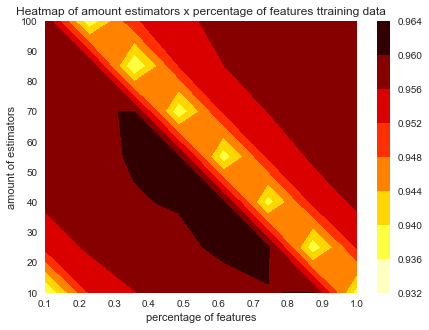

In [34]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (7,5)

xValues = []
yValues = []
for param in GSRandomForestComplete.cv_results_["params"]:
    xValues.append(param["max_features"])
    yValues.append(param["n_estimators"])

xValues = np.unique(xValues)
yValues = np.unique(yValues)
    
testSplitResults = []
trainSplitResults = []
for i in range(GSRandomForestComplete.n_splits_):        
    key = "split{}_test_score".format(i)
    testSplitResults.append(GSRandomForestComplete.cv_results_[key])
    key = "split{}_train_score".format(i)
    trainSplitResults.append(GSRandomForestComplete.cv_results_[key])
    
testResults = list(zip(*testSplitResults))
trainResults = list(zip(*trainSplitResults))

for i in range(len(testResults)):
    testResults[i] = np.mean(testResults[i][0])
    trainResults[i] = np.mean(trainResults[i][0])

testResults = np.reshape(testResults, (-1, len(xValues)))
trainResults = np.reshape(trainResults, (-1, len(xValues)))                      

plt.contourf(xValues, yValues, testResults);
plt.colorbar()
plt.set_cmap('hot_r')
#plt.plot(xValues, trainResults);
plt.xlabel('percentage of features')
plt.ylabel('amount of estimators')
plt.title('Heatmap of amount estimators x percentage of features test data')
plt.show();


plt.contourf(xValues, yValues, trainResults);
plt.colorbar()
plt.set_cmap('hot_r')
#plt.plot(xValues, trainResults);
plt.xlabel('percentage of features')
plt.ylabel('amount of estimators')
plt.title('Heatmap of amount estimators x percentage of features training data')
plt.show();


## Interpertation
First we notice that the grid search is very very expensive to calculate over the entire hyper param grid. Because all values are researched also insanely high values are tested. If total freedom was given it was probably a better idea to limit the grid by doing random searches to identify interesting areas and then do a gridsearch on that specific area.

Now about the results. There is a very clear line visible over the diagonal where the results are very bad. This is logical since extremely large amount of trees on very little features results in overfitting. A high amount of features on a low amount of trees might also results in trees that are way too deep and also do overfitting.

When we stay away from the diagonal with our parameters we see a very very small optimum between 60 and 70 percent of the features and 20 to 40 trees. In this area there might be more to gain, but under the diagonal the results are practically the same.

Also when we look at the training data we see almost perfect prediction in most areas. This indicates that there is also an optimum that is almost reached and an overfit might also happen. Lastly it might be that the results are better than they should be because there are a lot of features with useful meanings and a lot of data that can be used. Due to that overfitting does not happen so soon and noise has less influence

## 3. Understanding Ensembles (5 points (3+2))
Do a deeper analysis of how RandomForests and Gradient Boosting reduce their prediction error. We'll use the MAGIC telescope dataset (http://www.openml.org/d/1120). When high-energy particles hit the atmosphere, they produce chain reactions of other particles called 'showers', and you need to detect whether these are caused by gamma rays or cosmic rays.

In [9]:
# Get the data
magic_data = oml.datasets.get_dataset(1120) # Download MAGIC Telescope data
X, y = magic_data.get_data(target=magic_data.default_target_attribute);

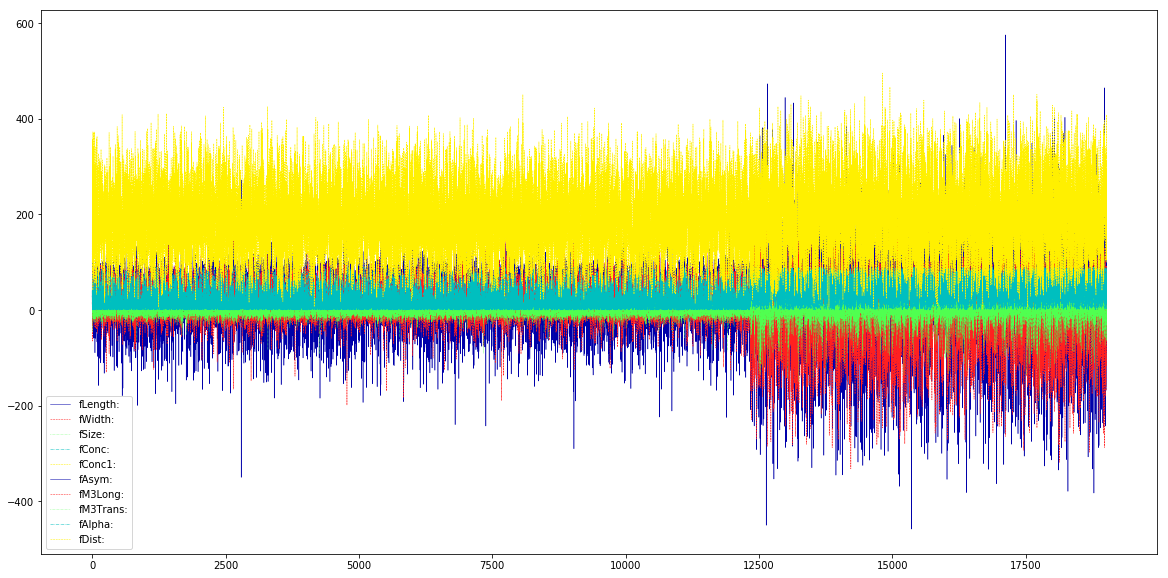

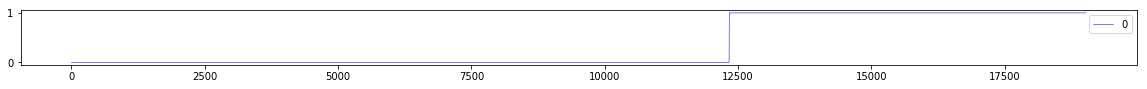

In [10]:
# Quick visualization
X, y, attribute_names = magic_data.get_data(target=magic_data.default_target_attribute, return_attribute_names=True)
magic = pd.DataFrame(X, columns=attribute_names)
magic.plot(figsize=(20,10))
# Also plot the target: 1 = gamma, 0 = background
pd.DataFrame(y).plot(figsize=(20,1));

1 . Do a bias-variance analysis of both algorithms. For each, vary the number of trees on a log scale from 1 to 1024, and plot the bias error (squared), variance, and total error (in one plot per algorithm). Interpret the results. Which error is highest for small ensembles, and which reduced most by each algorithm as you use a larger ensemble? When are both algorithms under- or overfitting? Provide a detailed explanation of why random forests and gradient boosting behave this way.
- See lecture 3 for an example on how to do the bias-variance decomposition
- To save time, you can use a 10% stratified subsample in your initial experiments, but show the plots for the full dataset in your report.

### 2.1 interpretation of results
Because of the time it takes to learn, we were unable to fit 1024 trees.

Bias is associated with underfitting, variance with overfitting.
We have no explanation of why bias would go up when fitting more trees. However it is an indication that we are underfitting.

In [45]:
from sklearn.ensemble import RandomForestClassifier  
from sklearn.model_selection import ShuffleSplit

nrOfTrees = np.logspace(0,8, base=2, num=20)
nrOfTrees = np.ndarray.tolist(nrOfTrees.astype(int))
nrOfTrees = sorted(list(set(nrOfTrees)))
print(nrOfTrees)
n_repeat = 50
shuffle_split = ShuffleSplit(test_size=0.33, n_splits=n_repeat)
errors = []

# Store sample predictions


# Train classifier on each bootstrap and score predictions
for n in nrOfTrees:
    y_all_pred = [[] for _ in range(len(y))]
    for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
        # Train and predict
        forest = RandomForestClassifier(n_estimators=n, random_state=2,n_jobs=3)
        forest.fit(X[train_index], y[train_index])
        y_pred = forest.predict(X[test_index])
        # Store predictions
        for i,index in enumerate(test_index):
            y_all_pred[index].append(y_pred[i])

    # Compute bias, variance, error
    bve = [None] * 3
    bve[0] = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat for i,x in enumerate(y_all_pred)])
    bve[1] = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat for i,x in enumerate(y_all_pred)])
    bve[2] = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat for i,x in enumerate(y_all_pred)])
    errors.append(bve)
    print(n) 
errors = pd.DataFrame(errors, columns= ['bias', 'variance', 'error'], index = nrOfTrees)
errors

[1, 2, 3, 4, 5, 7, 10, 13, 18, 24, 33, 44, 59, 79, 106, 142, 191, 256]
1
2
3
4
5
7
10


KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

nrOfTrees = np.logspace(0,8, base=2, num= 20)
nrOfTrees = np.ndarray.tolist(nrOfTrees.astype(int))
nrOfTrees = sorted(list(set(nrOfTrees)))
print(nrOfTrees)
n_repeat = 50
shuffle_split = ShuffleSplit(test_size=0.33, n_splits=n_repeat)
errors2 = []

# Store sample predictions


# Train classifier on each bootstrap and score predictions
for n in nrOfTrees:
    y_all_pred = [[] for _ in range(len(y))]
    for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
        # Train and predict
        gbc = GradientBoostingClassifier(n_estimators=n, random_state=2)
        gbc.fit(X[train_index], y[train_index])
        y_pred = forest.predict(X[test_index])
        # Store predictions
        for i,index in enumerate(test_index):
            y_all_pred[index].append(y_pred[i])

    # Compute bias, variance, error
    bve = [None] * 3
    bve[0] = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat for i,x in enumerate(y_all_pred)])
    bve[1] = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat for i,x in enumerate(y_all_pred)])
    bve[2] = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat for i,x in enumerate(y_all_pred)])
    errors2.append(bve)
    print(n) 
errors2 = pd.DataFrame(errors, columns= ['bias', 'variance', 'error'], index = nrOfTrees)
errors2

In [ ]:
errors.to_pickle('randomForestErrors.pkl')
errors2.to_pickle('gradientBoosterErrors.pkl')

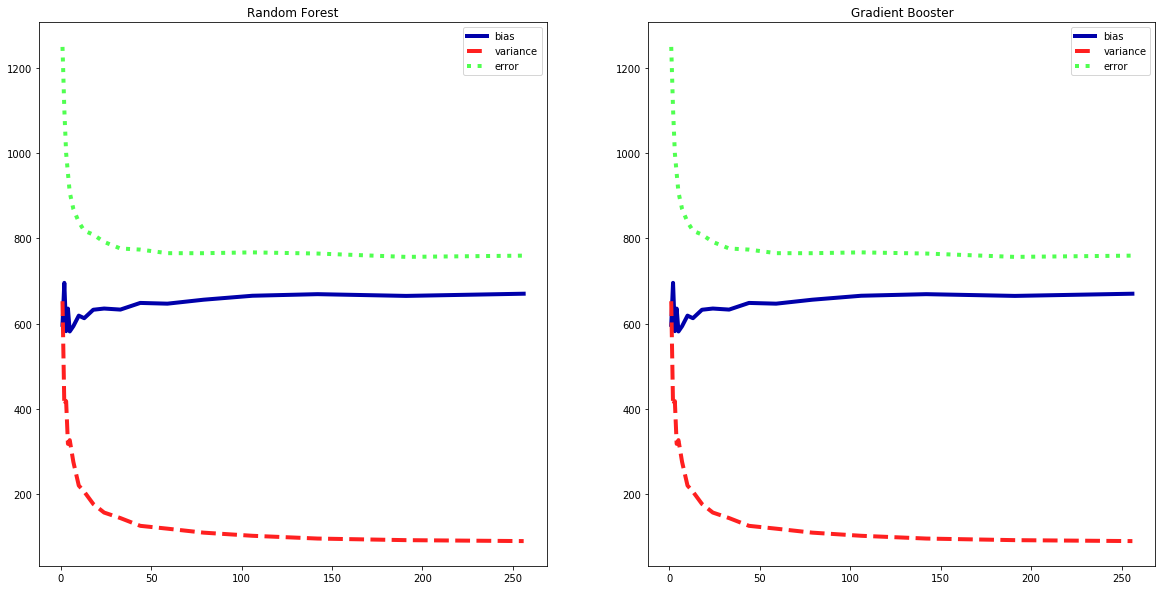

In [50]:
errors = pd.read_pickle('randomForestErrors.pkl')
errors2 = pd.read_pickle('gradientBoosterErrors.pkl')
fig, ax = plt.subplots(ncols=2, squeeze=False)
errors.plot(ax=ax[0,0], title='Random Forest', figsize=(20,10), linewidth=4)
errors2.plot(ax=ax[0,1], title='Gradient Booster', figsize=(20,10), linewidth=4)

2 . A _validation curve_ can help you understand when a model starts under- or overfitting. It plots both training and test set error as you change certain characteristics of your model, e.g. one or more hyperparameters. Build validation curves for gradient boosting, evaluated using AUROC, by varying the number of iterations between 1 and 500. In addition, use at least two values for the learning rate (e.g. 0.1 and 1), and tree depth (e.g. 1 and 4). This will yield at least 4 curves. Interpret the results and provide a clear explanation for the results. When is the model over- or underfitting? Discuss the effect of the different combinations learning rate and tree depth and provide a clear explanation.
- While scikit-learn has a `validation_curve` function, we'll use a modified version (below) that provides a lot more detail and can be used to study more than one hyperparameter. You can use a default train-test split.

In [ ]:
# Plots validation curves for every classifier in clfs. 
# Also indicates the optimal result by a vertical line
# Uses 1-AUROC, so lower is better
from sklearn.metrics import roc_auc_score
def validation_curve(clfs, X_test, y_test, X_train, y_train):
    for n,clf in enumerate(clfs):
        test_score = np.empty(len(clf.estimators_))
        train_score = np.empty(len(clf.estimators_))

        for i, pred in enumerate(clf.staged_decision_function(X_test)):
            test_score[i] = 1-roc_auc_score(y_test, pred)

        for i, pred in enumerate(clf.staged_decision_function(X_train)):
            train_score[i] = 1-roc_auc_score(y_train, pred)

        best_iter = np.argmin(test_score)
        learn = clf.get_params()['learning_rate']
        depth = clf.get_params()['max_depth']
        test_line = plt.plot(test_score, '-',
                             label='learn=%.1f depth=%i (%.2f)'%(learn,depth,
                                                                 test_score[best_iter]), linewidth=2)

        colour = test_line[-1].get_color()
        plt.plot(train_score, '--', color=colour, linewidth=2)
        
        plt.xlabel("Number of boosting iterations")
        plt.ylabel("1 - area under ROC")
        plt.axvline(x=best_iter, color=colour)
        
    plt.legend(loc='best')
    plt.figure(figsize=(30,20))

In [ ]:
learningRates = [0.1,1]
deptTree = [1,4]
# iterations = np.logspace(0,9, base=2, num=30)
# iterations = np.ndarray.tolist(iterations.astype(int))
# iterations = sorted(list(set(iterations)))

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=123, stratify=y);

clfs = []
# for n in iterations:
for lr in learningRates:
    for d in deptTree:
        clf = GradientBoostingClassifier(learning_rate=lr, n_estimators=500, max_depth=d)
        clf.fit(x_train,y_train)
        clfs.append(clf)
print(n)


In [ ]:
validation_curve(clfs, x_test, y_test, x_train, y_train)

### 2.2 interpretation of results
We can see that with small numbers of iterations both training and test scores are high meaning the model underfits. With more iteration this becomes better

If we restrict the tree to have a maximum depth of 1 and set the learning rate to 0.1, we can see that training and test scores remain high even with increasing nr of iteration, meaning the model underfits.

In the case where the maximum dept is 1 but the learning rate is 1, we can see that the scores imporve for a lower numer of iteration.We can see that the train and test scores are close.

In the case where the maximum dept is 4 and the learning rate is 0.1, we can see that the test results are the best compared to other parameter combinations. We can see that with increasing number of iterations the train score improves but the test score does not.

The case where the maximum dept is 4 and the learning rate is 1, is a clear case of overfitting. The trainscore rapidly decreases even with a small number of iterations. The test scores however after a initial decrease, only increase for the first 100 iteration, meaning that the model overfits on the training data.